## Problem 3

### Environment Setup
Make sure to change the DATA_DIR if running on your machine.

In [1]:
# env setup
import os
import time
import pandas as pd
import numpy as np
from itertools import repeat
import matplotlib.pyplot as plt

#EDIT with your working DIR
DATA_DIR = "/home/jack/Documents/Advanced-ML-Course/Assignment_2/data"

In [2]:
# read in the data
svm_data = pd.read_csv(os.path.join(DATA_DIR, "svm.csv"))

# save data for model
x_test = svm_data[["x","y", "intercept"]].to_numpy()
y_test = svm_data["class"].to_numpy()

### SVM with Subgradient Design

The write-up is in the pdf of the homework.

In [167]:
hindge_loss = lambda w, X, y : np.maximum((1 - (X.dot(w) * y)), 0)
"""hinge loss method for subgradient updates"""

def subgradient_updates(y, w, X, C = 0.8, lambd = 0.1):
    """
    Compute the hindge loss and weight updates.
    Returns averaged update for batch and the average loss for batch.

    Parameters
    ----------
    y: np.array(shape=(batch_size,)), class values {-1, +1}
    w: np.array(shape=(feature_size,)), weight vector
    X: np.array(shape=(batch_size,feature_size)), training examples

    lambd: double, parameter in regularization term
    C: double, control parameter for gradient updates

    Returns
    -------
    tuple, ( np.array(shape=(feature_size)), updates for w, loss)

    """
    
    batch_size = y.shape[0]
    subgradients = np.zeros((batch_size, w.shape[0]))

    total_loss = hindge_loss(w, X, y)
    
    # calculate subgradients for correct examples
    subgradients[np.where(total_loss == 0)] = lambd * w
   
    # calculate subgradients for incorrect examples
    update_values = np.apply_along_axis(lambda x: (x*y[np.where(total_loss != 0)]), 0, X[np.where(total_loss != 0)])
    #print(update_values)
    subgradients[np.where(total_loss != 0)] = np.repeat([lambd*w], update_values.shape[0], axis=0) - C * update_values
    #print(subgradients)
    # calculate average of subgradients
    if batch_size != 1:
        return np.average(subgradients, axis=0), np.asscalar(np.average(total_loss))
    else: 
        return subgradients.reshape((3,)), np.asscalar(total_loss)


def fit_svm(X, y, C = 2, lambd = 0.1, learning_rate = 0.5, batch_size = 16, epochs=10, random_seed=83):
    """
    Fits an SVM model.  Assumes you feed in an intercept feature with your data. 

    Parameters
    ----------
    X: np.array(shape=(data_size,feature_size)), training examples
    y: np.array(shape=(data_size,)), class values {-1, +1}

    C: double, control parameter for gradient updates
    lambd: double, parameter in regularization term
    learning_rate: double, learning rate (i.e. eta)
    batch_size: int, the size for each gradient descent step
    epochs: int, the number of passes on the data
    random_seed: int, random seed for numpy and weight initalization

    Returns
    -------
    tuple, (w, w_historic_values, loss): np.array() of final weights, list of all previous weights, list of all loss.
    """
    
    # randomly initalize values for w
    np.random.seed(seed=random_seed)
    w = np.random.uniform(high=5, low=-5, size=(x_test.shape[1],))

    # batch the data
    batches = np.repeat(batch_size, X.shape[0] // batch_size)
    remainder = X.shape[0] % batch_size
    if remainder != 0:  batches = np.append(batches, [remainder])

    X_batched = np.array_split(X, np.cumsum(batches))[:-1]
    y_batched = np.array_split(y, np.cumsum(batches))[:-1]
    #print(X_batched)

    # run training for all epochs
    w_historic_values = [w]
    losses = []
    for i in repeat(None, epochs):
        for x_batch, y_batch in zip(X_batched, y_batched):
            
            # update w and calculate loss
            w_update, loss = subgradient_updates(y=y_batch, w=w, X=x_batch, C = C, lambd = lambd)
            new_w = w - (learning_rate * w_update)
            w_historic_values.append(new_w)
            losses.append(loss)
            
            w = new_w

    return w, w_historic_values, losses

def classify_data(w, X):
    """
    Classifies dataset.  Assumes you feed in an intercept feature with your data. 

    Parameters
    ----------
    w: np.array(shape=(feature_size,)), weight vector
    X: np.array(shape=(data_size,feature_size)), training examples

    Returns
    -------
    np.array(shape=(data_size,)), array with classifications
    """
    
    output = np.apply_along_axis(lambda x: x.dot(w), 1, X)
    return np.where(output > 0, 1, -1)


### Results


#### The Impact of Batch Size

Batching and averaging data makes the algorithm much faster than an implementation for an online setting.  This is implemented with 10 epochs (i.e. n = 1,000)

In [176]:
batch_sizes = [32, 16, 8, 4, 2, 1]
wl_tuples = []
run_time = []
for batch in batch_sizes:
    start_time = time.time()
    wl_tuples.append(fit_svm(x_test, y_test, random_seed=99, batch_size = batch))
    run_time.append(time.time() - start_time)

**Decision Boundaries**

The variance and randomness of new decision boundaries is impacted by batch size.

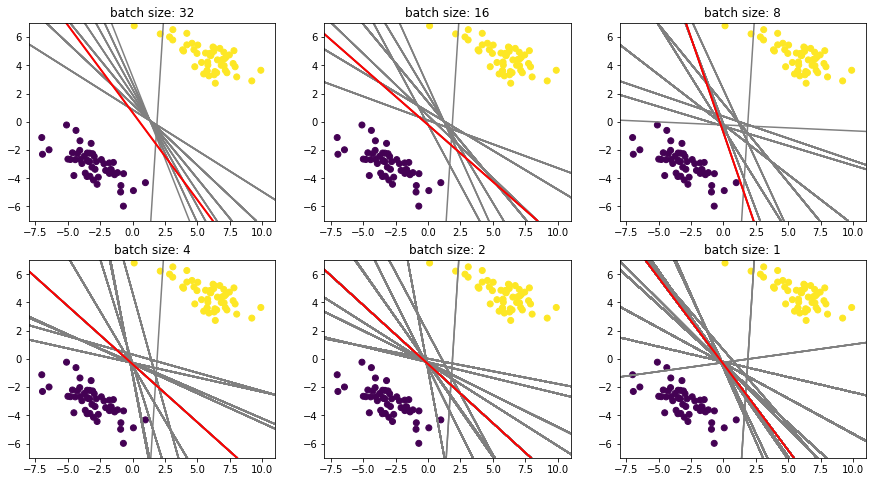

In [177]:
return_x1 = lambda w, x2: (w[2] - w[1] * x2) / w[0]
""" For this simple case, x2 (y) can be found by linearly solving for it, given x. """

# plot decision boundary
x2_lines = np.linspace(-7, 7, num=100)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

i = 0
for (m,n), subplot in np.ndenumerate(ax):
    subplot.set_xlim(-8,11)
    subplot.set_ylim(-7,7)
    subplot.set_title(f'batch size: {batch_sizes[i]}')
    
    subplot.scatter(x=svm_data.x, y=svm_data.y, c=svm_data["class"])

    w, w_historic, _ = wl_tuples[i]
            
    for w_old in w_historic[:-1]:
        x1_lines = return_x1(w_old, x2_lines)
        subplot.plot(x1_lines, x2_lines, color="grey")

    # plot final decision boundary
    x1_lines = return_x1(w, x2_lines)
    subplot.plot(x1_lines, x2_lines, color="red", linewidth=2)
    i = i + 1

**Loss** 

Often times, the total hindge loss was 0, which resulted in the decision boundary moving only by the regularization term.  Batch size impacts the frequency and magnitude of loss.  Smaller batch sizes increase the variance of loss because of increased randomness.

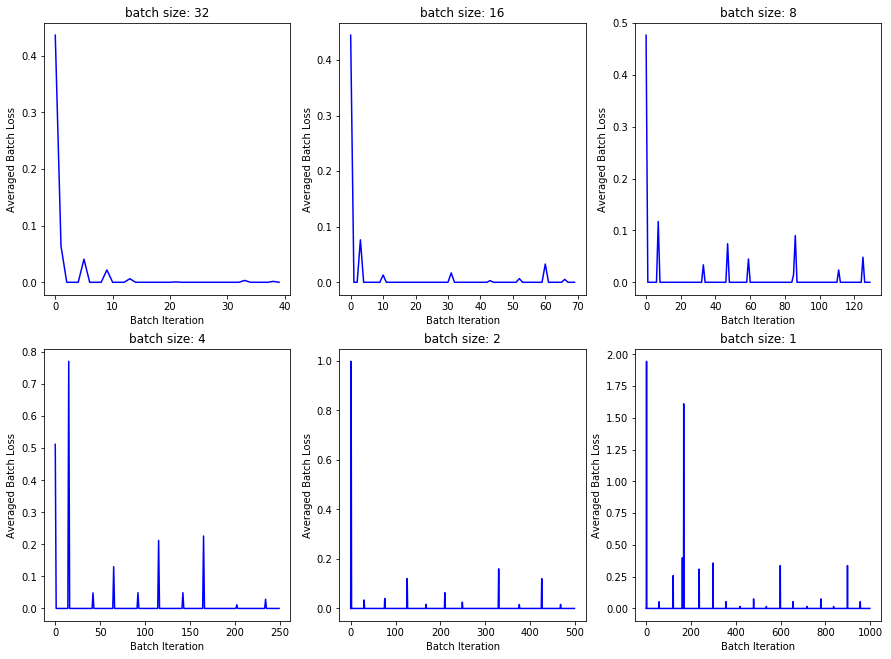

In [192]:
# plot decision boundary
fig, ax = plt.subplots(2, 3, figsize=(15, 11))

i = 0
for (m,n), subplot in np.ndenumerate(ax):
    subplot.set_ylabel('Averaged Batch Loss')
    subplot.set_xlabel('Batch Iteration')
    subplot.set_title(f'batch size: {batch_sizes[i]}')
    
    _, _, loss = wl_tuples[i]
    subplot.plot(range(len(loss)), loss, color="blue")
    i = i + 1

**Run Time**

The batch size also impacts run-time.  Higher batch sizes are correlated with smaller run times because must of the calculations can be done with matrix algebra, rather than through further iterations.  

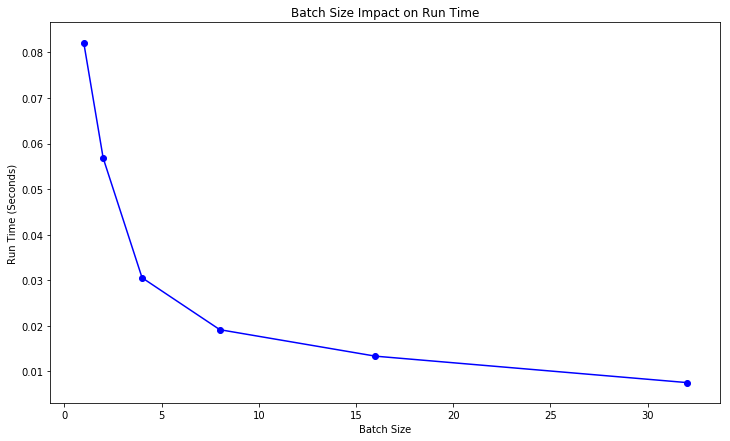

In [202]:
# plot decision boundary
fig, ax = plt.subplots(1, figsize=(12, 7))

ax.set_ylabel('Run Time (Seconds)')
ax.set_xlabel('Batch Size')
ax.set_title(f'Batch Size Impact on Run Time')

ax.plot(batch_sizes, run_time, color="blue")
ax.scatter(batch_sizes, run_time, color="blue")


#### The Impact of Epochs (n)

Running the model on more data will impact the model run time.

In [211]:
epochs = [1,10,20,50,100,500]
wl_tuples = []
run_time = []
for epoch in epochs:
    start_time = time.time()
    wl_tuples.append(fit_svm(x_test, y_test, random_seed=99, batch_size = 8, epochs=epoch))
    run_time.append(time.time() - start_time)

**Decision Boundaries**

The more data you have, the more likely it is you'll have a higher variance of intermediate decision boundaries.

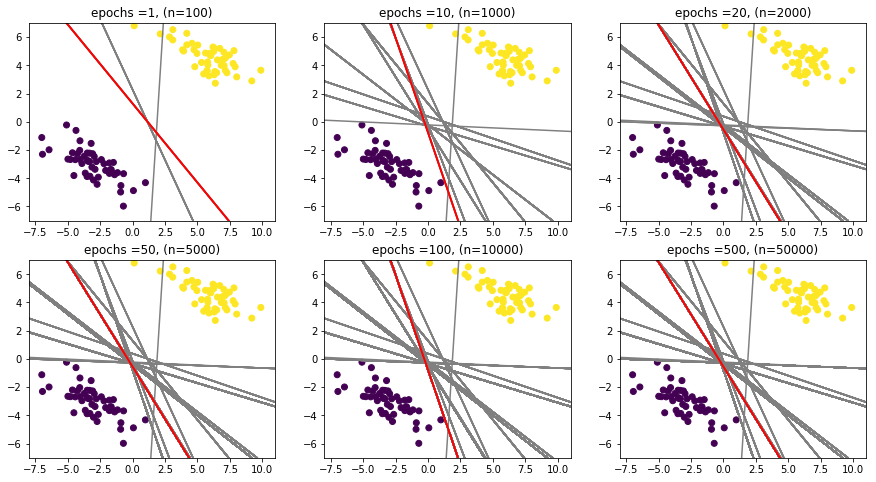

In [213]:
# plot decision boundary
x2_lines = np.linspace(-7, 7, num=50)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

i = 0
for (m,n), subplot in np.ndenumerate(ax):
    subplot.set_xlim(-8,11)
    subplot.set_ylim(-7,7)
    subplot.set_title(f'epochs ={epochs[i]}, (n={epochs[i]*100})')
    
    subplot.scatter(x=svm_data.x, y=svm_data.y, c=svm_data["class"])
    w, w_historic, _ = wl_tuples[i]
            
    for w_old in w_historic[:-1]:
        x1_lines = return_x1(w_old, x2_lines)
        subplot.plot(x1_lines, x2_lines, color="grey")

    # plot final decision boundary
    x1_lines = return_x1(w, x2_lines)
    subplot.plot(x1_lines, x2_lines, color="red", linewidth=2)
    i = i + 1

**Loss** 

These loss plots are showing that after a certain point the model is just iterating between a few differnt possible states and corresponding losses.  At that point it would make sense to do some hyperparameter tuning.

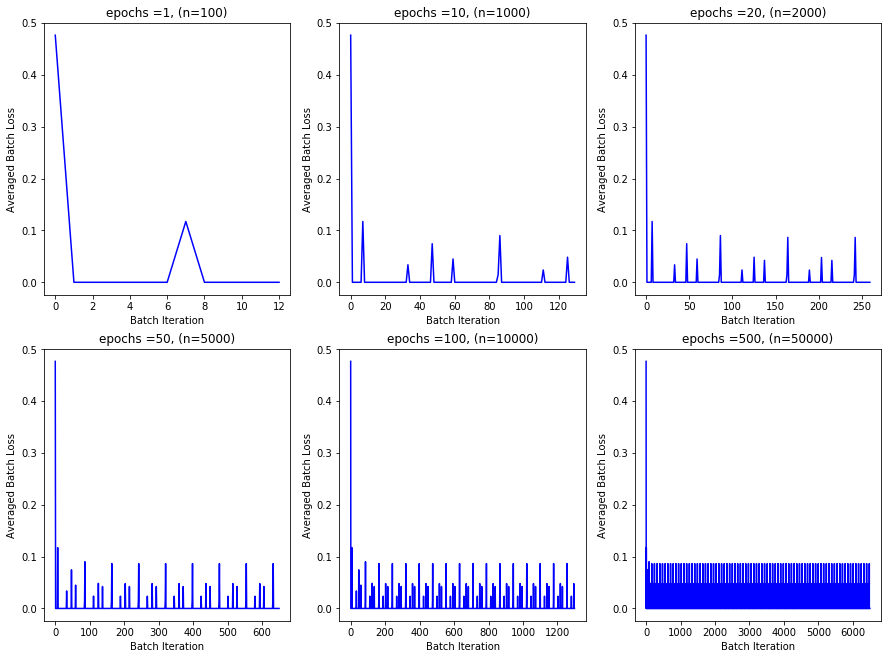

In [214]:
# plot decision boundary
fig, ax = plt.subplots(2, 3, figsize=(15, 11))

i = 0
for (m,n), subplot in np.ndenumerate(ax):
    subplot.set_ylabel('Averaged Batch Loss')
    subplot.set_xlabel('Batch Iteration')
    subplot.set_title(f'epochs ={epochs[i]}, (n={epochs[i]*100})')
    
    _, _, loss = wl_tuples[i]
    subplot.plot(range(len(loss)), loss, color="blue")
    i = i + 1

**Run Time**

Unlike with batching, there is a very linear relationship between run time and the amount of data you train on.

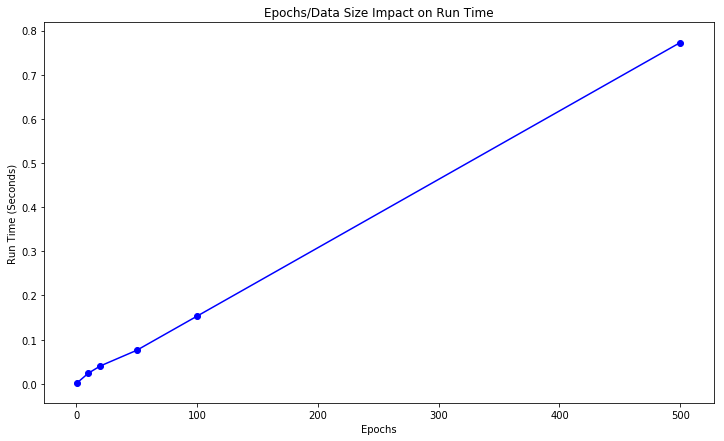

In [216]:
# plot decision boundary
fig, ax = plt.subplots(1, figsize=(12, 7))

ax.set_ylabel('Run Time (Seconds)')
ax.set_xlabel('Epochs')
ax.set_title(f'Epochs/Data Size Impact on Run Time')

ax.plot(epochs, run_time, color="blue")
ax.scatter(epochs, run_time, color="blue")
